# Packages


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# libraries
from operator import itemgetter
from IPython.display import display_html
from math import sqrt

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import folium
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools

# Explor

## Constructing the networks

In [3]:
# read in london.graph.xml
G = nx.read_graphml("london.graph")

In [4]:
type(G)

networkx.classes.graph.Graph

In [5]:
# list all operations of the G object
print(len(dir(G)))
for i in np.random.randint(0, len(dir(G)), 10):
    print(dir(G)[i])

76
add_weighted_edges_from
edge_subgraph
__sizeof__
add_node
__sizeof__
__sizeof__
__dir__
__len__
copy
__subclasshook__


In [6]:
print(G.number_of_nodes())
print(G.number_of_edges())

401
467


In [7]:
# compute all possible nodes
print(G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1)))

0.0029114713216957604


In [8]:
# To check node attributes:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [9]:
# since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [10]:
# To check node attributes again:
list(G.nodes(data = True))[0]

('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)})

In [11]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356})

In [12]:
# To check edges type:
type(list(G.edges(data = True)))

list

In [13]:
# add station_name attribute to node
node_name = {}
for i in list(G.nodes(data = True)):
    node_name[i[0]] = i[0]
nx.set_node_attributes(G,node_name,'station_name')

In [14]:
# we can also add the stations name to the edge attributes from the nodes attributes:

nod_name1={(e1,e2):(G.nodes[e1]['station_name']) for e1, e2 in G.edges()}
nod_name2={(e1,e2):(G.nodes[e2]['station_name']) for e1, e2 in G.edges()}

nx.set_edge_attributes(G,nod_name1,'station_1')
nx.set_edge_attributes(G,nod_name2,'station_2')

In [15]:
# To check edges attributes again:
list(G.edges(data = True))[0]

('Wembley Park',
 'Kingsbury',
 {'length': 2916.7715580506483,
  'line_name': 'Jubilee',
  'flows': 12356,
  'station_1': 'Wembley Park',
  'station_2': 'Kingsbury'})

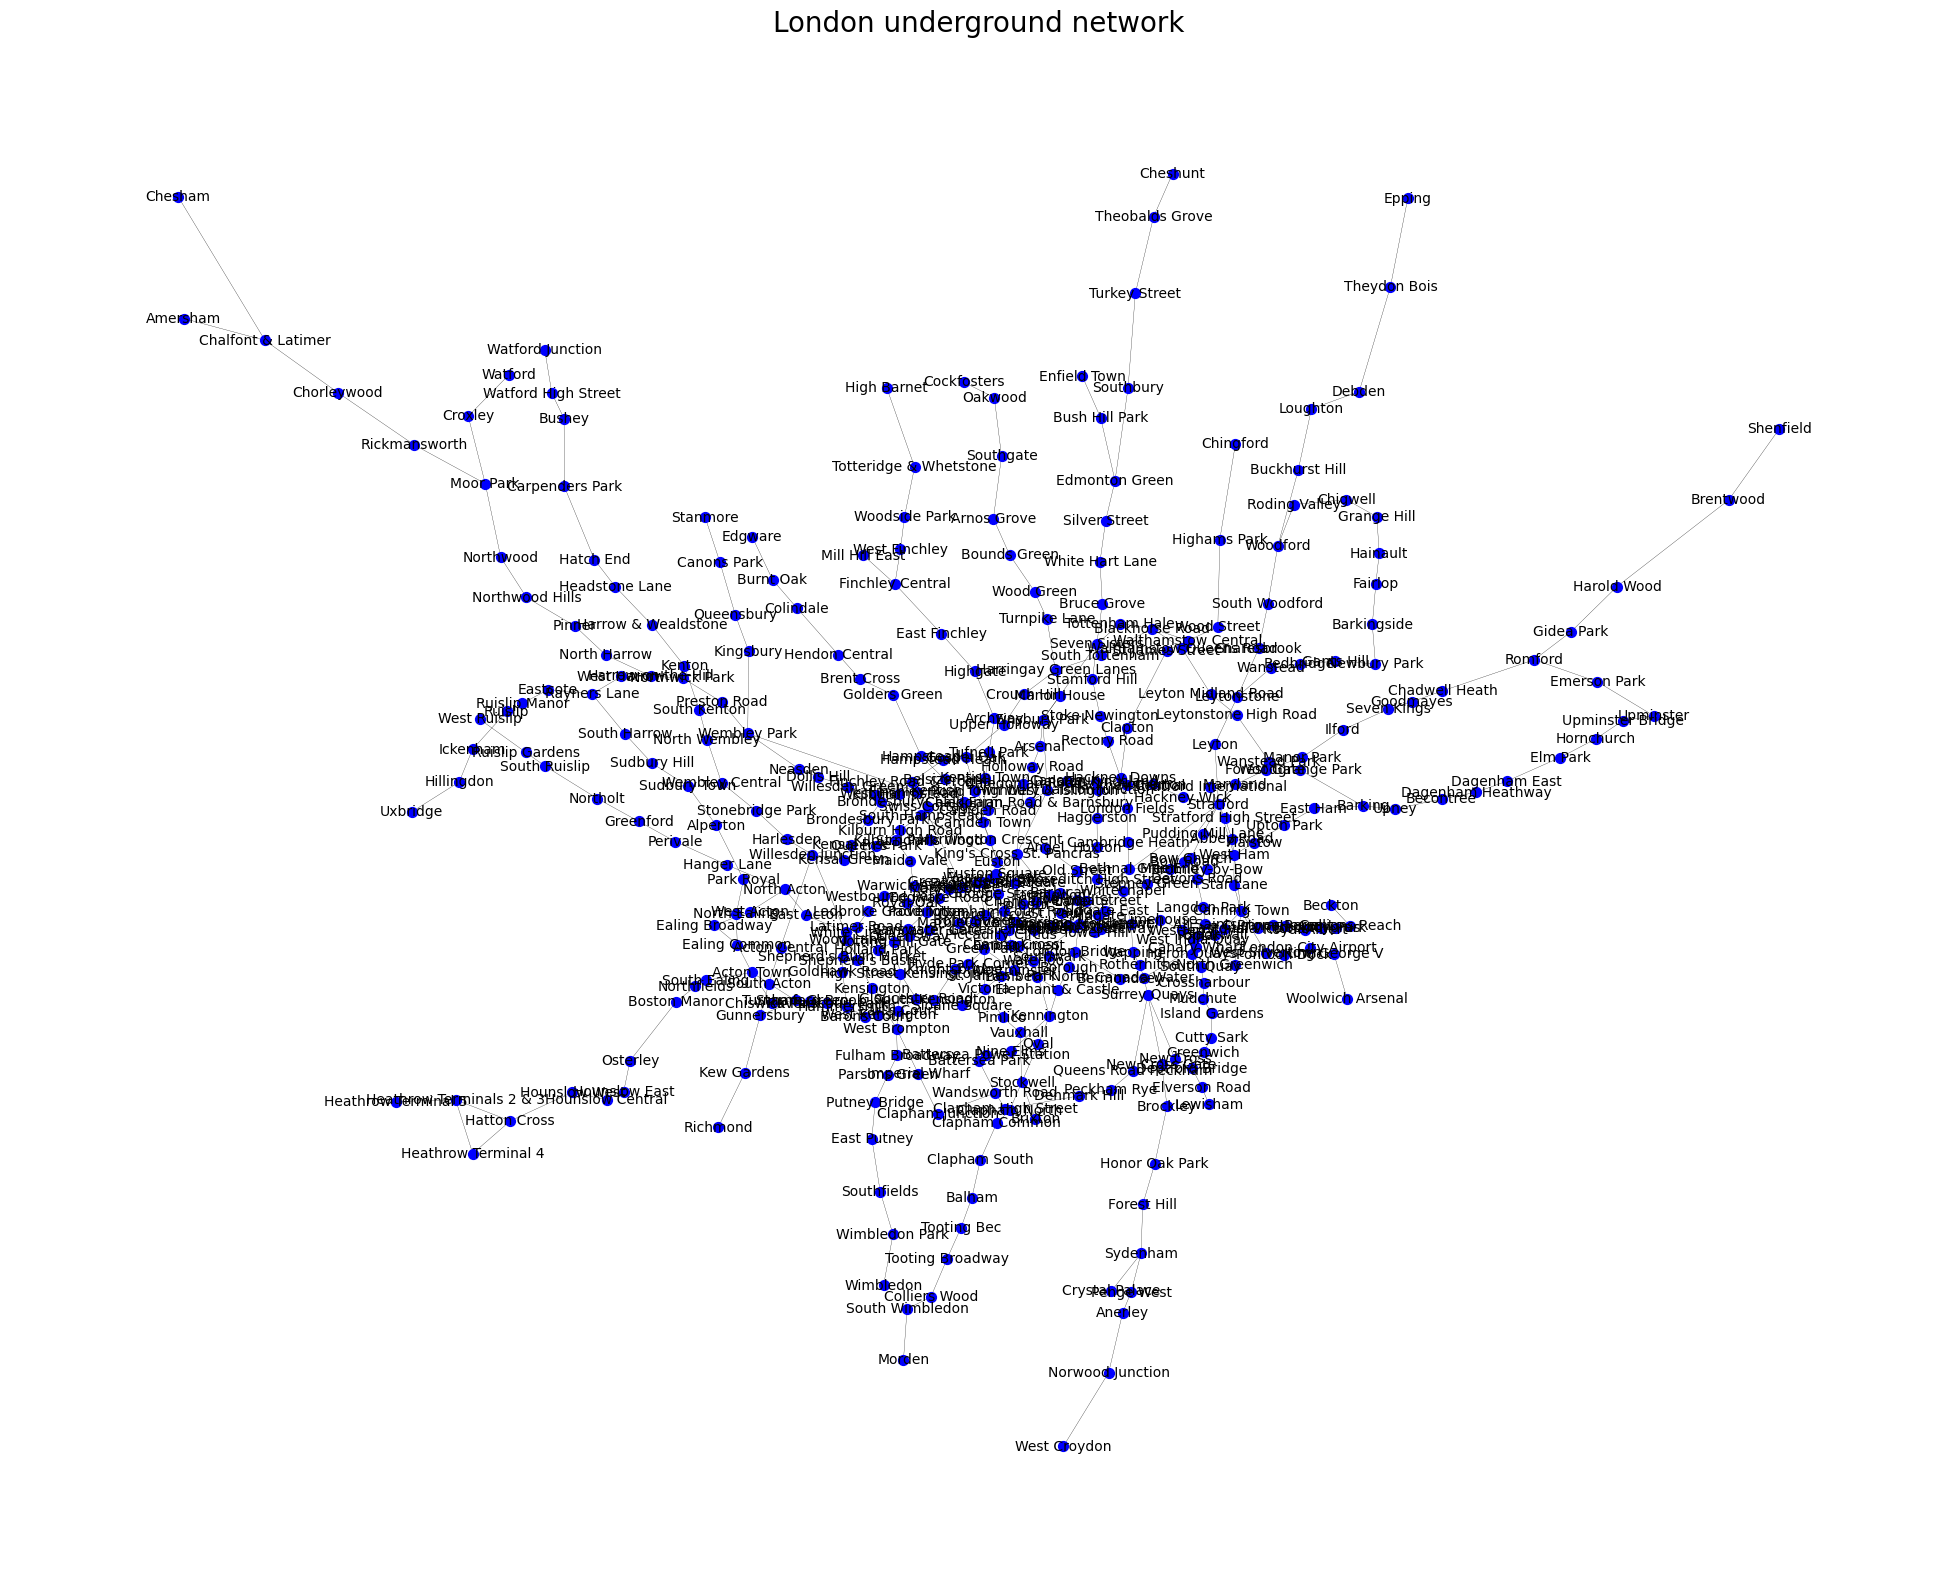

In [16]:
# Plot the tube network to check
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G, 'station_name')

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London underground network",fontsize=20)
plt.axis("off")
plt.savefig('underground.png')
plt.show()

In [17]:
# check edge list
df = nx.to_pandas_edgelist(G)
df.head(10)

,source,target,flows,station_2,length,line_name,station_1
0,Wembley Park,Kingsbury,12356,Kingsbury,2916.771558,Jubilee,Wembley Park
1,Wembley Park,Neasden,6744,Neasden,2353.165938,Jubilee,Wembley Park
2,Wembley Park,Preston Road,36601,Preston Road,1419.735166,Metropolitan,Wembley Park
3,Wembley Park,Finchley Road,55216,Finchley Road,7266.373927,Metropolitan,Wembley Park
4,Kingsbury,Queensbury,9419,Queensbury,1245.995234,Jubilee,Kingsbury
5,Queensbury,Canons Park,6385,Canons Park,1693.307343,Jubilee,Queensbury
6,Canons Park,Stanmore,3624,Stanmore,1419.669476,Jubilee,Canons Park
7,Stratford,West Ham,91801,West Ham,1673.509515,Jubilee,Stratford
8,Stratford,Mile End,12010,Mile End,2805.001392,Central,Stratford
9,Stratford,Leyton,56082,Leyton,2131.342926,Central,Stratford


# Part 1: London’s Underground Resilience

## I.Topological Network

### I.1 Centrality Measures

#### Closeness Centrality
Definition:Closeness Centrality is a score that indicates how close a node is to all other nodes in the network, based on the shortest paths.

Why choose: Identifies stations that offer the shortest average journey time to all other stations.
\begin{equation} C_{i}= \frac{1}{l_{i}} = \frac{n}{\sum_{j} d_{ij}}\end{equation}

#### Betweeness Centrality
Definition:Betweeness Centrality measures the extent to which a node lies on the shortest path between other nodes in the network.

Why choose: Identifies stations that , if closed, would cause the greatest increase in journey times across the network
\begin{equation} C_{b}(v) = \sum_{s,t \neq v} \frac{\sigma_(s)(t)(v)}{\sigma_{st}} \end{equation}    

#### Eigenvector Centrality
Definition: Eigenvector Centrality takes into account not only the number of direct connections of a node, but also the quality of these connected nodes (their own connections).

Why choose: In a transport network, using Degree Centrality it is possible to find out which stations have a high number of connections, but this does not necessarily mean that the station is very important, as it may be a connecting station used to switch routes. Eigenvector Centrality, on the other hand, measures not only the number of connections at a site, but also the number of connections at the sites it connects to. Sites with high values from Eigenvector Centrality are likely to be more important points in the network.
\begin{equation} x_v = \frac{1}{\lambda}\sum_{t\in M(v)} x_t\end{equation}n}

#### Topological Closeness Centrality

In [18]:
#topological closeness centrality
clos_t=nx.closeness_centrality(G)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,clos_t,'closeness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['closeness_t'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))

df_clos_t = df.sort_values(["closeness_t"], ascending=False)
df_clos_t[0:10]

,station_name,closeness_t
Green Park,Green Park,0.114778
Bank and Monument,Bank and Monument,0.113572
King's Cross St. Pancras,King's Cross St. Pancras,0.113443
Westminster,Westminster,0.112549
Waterloo,Waterloo,0.112265
Oxford Circus,Oxford Circus,0.111204
Bond Street,Bond Street,0.110988
Farringdon,Farringdon,0.110742
Angel,Angel,0.110742
Moorgate,Moorgate,0.110314


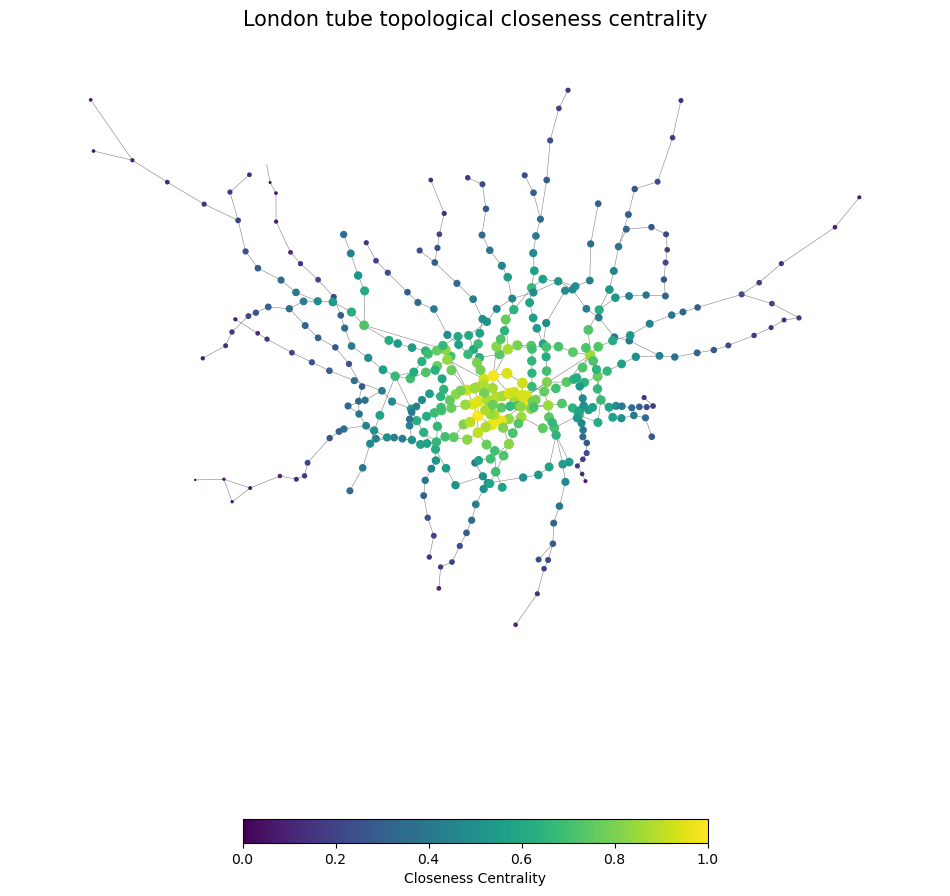

In [19]:
# Lets set color and width of nodes according to the closeness values
clos_t_val=[(i[1]['closeness_t']) for i in G.nodes(data=True)]

closs_t_color=[(i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val)) for i in G.nodes(data=True)]
closs_t_size=[((i[1]['closeness_t']-min(clos_t_val))/(max(clos_t_val)-min(clos_t_val))*50) for i in G.nodes(data=True)]


# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', 
        width=0.4)

nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= closs_t_color,
        node_size= closs_t_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological closeness centrality",fontsize=15)
plt.savefig('clos.png')
plt.show()

#### Topological Betweeness Centrality

In [20]:
# topological betweenness centrality:

bet_t=nx.betweenness_centrality(G, normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G,bet_t,'betweenness_t')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['betweenness_t'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

df_bet_t = df.sort_values(["betweenness_t"], ascending=False)
df_bet_t[0:10]

,station_name,betweenness_t
Stratford,Stratford,23768.093434
Bank and Monument,Bank and Monument,23181.058947
Liverpool Street,Liverpool Street,21610.387049
King's Cross St. Pancras,King's Cross St. Pancras,20373.521465
Waterloo,Waterloo,19464.882323
Green Park,Green Park,17223.622114
Euston,Euston,16624.275469
Westminster,Westminster,16226.155916
Baker Street,Baker Street,15287.107612
Finchley Road,Finchley Road,13173.758009


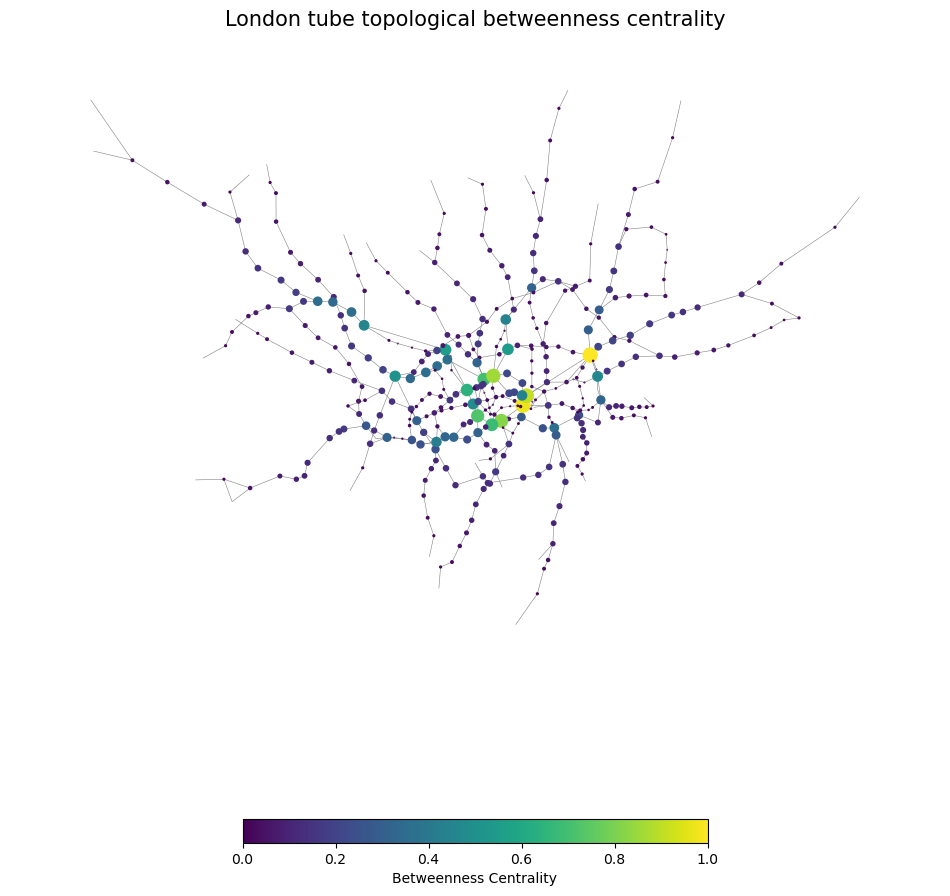

In [21]:
# Lets set colour and size of nodes according to betweenness values
betweenness_t_values=[(i[1]['betweenness_t']) for i in G.nodes(data=True)]

bet_t_color=[(i[1]['betweenness_t']/max(betweenness_t_values)) for i in G.nodes(data=True)]
bet_t_size=[(i[1]['betweenness_t']/max(betweenness_t_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G, pos = pos, node_color= bet_t_color, node_size= bet_t_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological betweenness centrality",fontsize=15)
plt.savefig('bet.png')
plt.show()

#### Eigenvector Centrality

In [22]:
#eigenvector centrality
eig_centrality = nx.eigenvector_centrality(G, max_iter=1000)
# We can add these values to the nodes attributes:
nx.set_node_attributes(G, eig_centrality, 'eigenvector_centrality')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G, 'station_name'))
df['eigenvector_centrality'] = pd.Series(nx.get_node_attributes(G, 'eigenvector_centrality'))

df_eig = df.sort_values(["eigenvector_centrality"], ascending=False)
df_eig.head(10)

,station_name,eigenvector_centrality
Bank and Monument,Bank and Monument,0.383427
Liverpool Street,Liverpool Street,0.328824
Stratford,Stratford,0.269179
Waterloo,Waterloo,0.249731
Moorgate,Moorgate,0.215137
Green Park,Green Park,0.197630
Oxford Circus,Oxford Circus,0.184094
Tower Hill,Tower Hill,0.171676
Westminster,Westminster,0.168610
Shadwell,Shadwell,0.159090


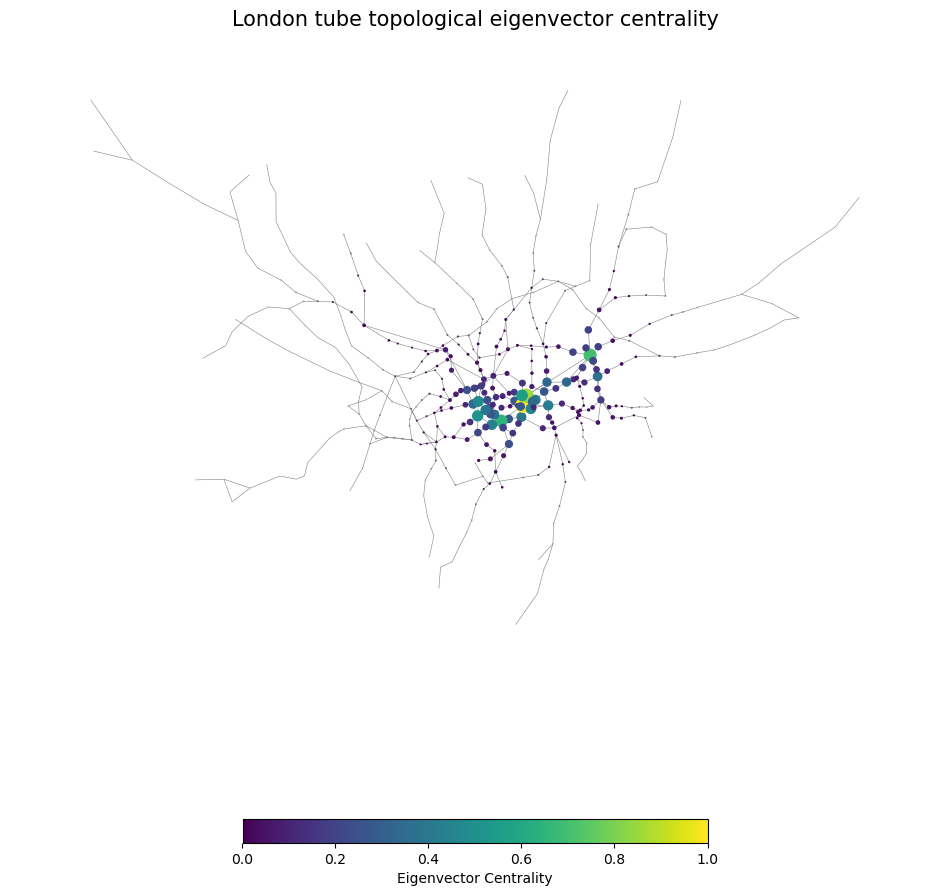

In [23]:
# Lets set colour and size of nodes according to eigenvector values
eigenvector_centrality_values = [(i[1]['eigenvector_centrality']) for i in G.nodes(data=True)]

eig_centrality_color = [(i[1]['eigenvector_centrality']/max(eigenvector_centrality_values)) for i in G.nodes(data=True)]
eig_centrality_size = [(i[1]['eigenvector_centrality']/max(eigenvector_centrality_values))*100 for i in G.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4)

nod = nx.draw_networkx_nodes(G, pos=pos, node_color=eig_centrality_color, node_size=eig_centrality_size)

plt.colorbar(nod, label="Eigenvector Centrality", orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube topological eigenvector centrality", fontsize=15)
plt.savefig('eig.png')
plt.show()

### I.2Impact measures:

#### **Largest Component Component (LCC)**
Definition：
The number of nodes in the largest connected component of the network. This size not only reflects the connectivity in the network

Why Choose:
When a node is deleted, the maximum connected subgraph in the network will change. In the traffic network the largest one connectivity subgraph will ensure the connectivity of the whole network and the stability of the information transmission.

#### **Global Efficiency**
Definition：
A metric used in network theory to measure the overall communication efficiency of a network

Why Choose:
The connectivity of the network is affected when a node is removed, which leads to a reduction in global efficiency. Global efficiency can be used as a key metric to determine how the network is connected to improve the overall efficiency of information transfer.
\begin{equation} E_{\text{glob}}(G) = \frac{1}{N(N-1)} \sum_{i \neq j \in V} \frac{1}{d(i,j)}\end{equation}

#### Define Function

In [24]:
#Creating largest_component_size function
def largest_component_size(G):
    """Calculate the size of the largest connected component in the graph."""
    if nx.is_empty(G): 
        return 0
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc)

In [25]:
#The largest_component_size of the current G
print("Largest Component Size:", largest_component_size(G))

Largest Component Size: 401


In [26]:
#Creating global_efficiency function
def global_efficiency(G):
    """Calculate the global efficiency of the graph."""
    N = len(G)
    if N < 2: 
        return 0

    eff = 0.0
    for u in G.nodes():
        length = nx.single_source_shortest_path_length(G, u)
        eff += sum(1.0 / d for d in length.values() if d > 0)  # 只计算存在路径的节点对


    if N * (N - 1) == 0:
        return 0

    return eff / (N * (N - 1))  

In [27]:
#The global_efficiency of the current G
print("Global Efficiency:", global_efficiency(G))

Global Efficiency: 0.10125619359712325


In [28]:
def global_clustering_coefficient(G):
    """Calculate the global clustering coefficient of the graph."""
    if len(G) < 2:
        return 0

    return nx.transitivity(G)

In [29]:
#The global_efficiency of the current G
print("Global Clustering Coefficient:", global_clustering_coefficient(G))

Global Clustering Coefficient: 0.050119331742243436


### I.3Node removal

#### Creat Copies of G 

In [30]:
# creating non-sequential graphs
G_clos_ns = G.copy() #Topological Closeness Centrality
G_bet_ns = G.copy() #Topological Betweeness Centrality
G_eig_ns = G.copy() #Eigenvector Centrality

In [31]:
print("Number of nodes in G_clos_ns after copy:", G_clos_ns.number_of_nodes())
print("Number of edges in G_clos_ns after copy:", G_clos_ns.number_of_edges())

print("Number of nodes in G_bet_ns after copy:", G_bet_ns.number_of_nodes())
print("Number of edges in G_bet_ns after copy:", G_bet_ns.number_of_edges())

print("Number of nodes in G_eig_ns after copy:", G_eig_ns.number_of_nodes())
print("Number of edges in G_eig_ns after copy:", G_eig_ns.number_of_edges())

Number of nodes in G_clos_ns after copy: 401
Number of edges in G_clos_ns after copy: 467
Number of nodes in G_bet_ns after copy: 401
Number of edges in G_bet_ns after copy: 467
Number of nodes in G_eig_ns after copy: 401
Number of edges in G_eig_ns after copy: 467


In [32]:
# creating sequential graphs
G_clos_s = G.copy() #Topological Closeness Centrality
G_bet_s = G.copy() #Topological Betweeness Centrality
G_eig_s = G.copy() #Eigenvector Centrality

In [33]:
print("Number of nodes in G_clos_s after copy:", G_clos_s.number_of_nodes())
print("Number of edges in G_clos_s after copy:", G_clos_s.number_of_edges())

print("Number of nodes in G_bet_s after copy:", G_bet_s.number_of_nodes())
print("Number of edges in G_bet_s after copy:", G_bet_s.number_of_edges())

print("Number of nodes in G_eig_s after copy:", G_eig_s.number_of_nodes())
print("Number of edges in G_eig_s after copy:", G_eig_s.number_of_edges())

Number of nodes in G_clos_s after copy: 401
Number of edges in G_clos_s after copy: 467
Number of nodes in G_bet_s after copy: 401
Number of edges in G_bet_s after copy: 467
Number of nodes in G_eig_s after copy: 401
Number of edges in G_eig_s after copy: 467


#### No-sequential

In [34]:
#Topological Closeness Centrality
removed_nodes = []
component_sizes = []
efficiencies = []


for node in df_clos_t['station_name'][:10]:  
    if node in G_clos_ns.nodes:  
        G_clos_ns.remove_node(node)  
        removed_nodes.append(node)
        component_sizes.append(largest_component_size(G_clos_ns))
        efficiencies.append(global_efficiency(G_clos_ns))

results_clos_ns = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_clos_ns

,Removed Node,Largest Component Size,Global Efficiency
0,Green Park,400,0.099190
1,Bank and Monument,399,0.094872
2,King's Cross St. Pancras,398,0.087934
3,Westminster,397,0.087372
4,Waterloo,396,0.084859
5,Oxford Circus,395,0.082781
6,Bond Street,394,0.082581
7,Farringdon,393,0.082600
8,Angel,392,0.082622
9,Moorgate,389,0.081670


In [35]:
#Topological Betweeness Centrality


removed_nodes = []
component_sizes = []
efficiencies = []


for node in df_bet_t['station_name'][:10]:  
    if node in G_bet_ns.nodes:
        G_bet_ns.remove_node(node) 
        removed_nodes.append(node)
        component_sizes.append(largest_component_size(G_bet_ns))
        efficiencies.append(global_efficiency(G_bet_ns))


results_bet_ns = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_bet_ns

,Removed Node,Largest Component Size,Global Efficiency
0,Stratford,379,0.088917
1,Bank and Monument,378,0.085862
2,Liverpool Street,377,0.084963
3,King's Cross St. Pancras,371,0.078498
4,Waterloo,370,0.075942
5,Green Park,369,0.074152
6,Euston,346,0.068206
7,Westminster,345,0.067660
8,Baker Street,342,0.064700
9,Finchley Road,339,0.063139


In [36]:
#Eigenvector Centrality
removed_nodes = []
component_sizes = []
efficiencies = []


for node in df_eig['station_name'][:10]:
    if node in G_eig_ns.nodes: 
        G_eig_ns.remove_node(node)  
        removed_nodes.append(node)
        component_sizes.append(largest_component_size(G_eig_ns))
        efficiencies.append(global_efficiency(G_eig_ns))


results_eig_ns = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_eig_ns

,Removed Node,Largest Component Size,Global Efficiency
0,Bank and Monument,400,0.096735
1,Liverpool Street,399,0.094668
2,Stratford,377,0.084963
3,Waterloo,376,0.082797
4,Moorgate,375,0.082749
5,Green Park,374,0.080953
6,Oxford Circus,373,0.080104
7,Tower Hill,371,0.079741
8,Westminster,370,0.079100
9,Shadwell,368,0.077579


#### Sequential

In [37]:
#Topological Closeness Centrality
removed_nodes = []
component_sizes = []
efficiencies = []
clos_centrality = []  


for _ in range(10):
    if G_clos_s.number_of_nodes() == 0:
        break 
    

    centrality = nx.closeness_centrality(G_clos_s)
    

    highest_centrality_node = max(centrality, key=centrality.get)
    max_centrality_value = centrality[highest_centrality_node]  # 记录最高中心性值
    

    G_clos_s.remove_node(highest_centrality_node)
    

    largest_component_size_value = largest_component_size(G_clos_s)
    global_efficiency_value = global_efficiency(G_clos_s)


    removed_nodes.append(highest_centrality_node)
    component_sizes.append(largest_component_size_value)
    efficiencies.append(global_efficiency_value)
    clos_centrality.append(max_centrality_value)  


results_clos_s = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Centrality': clos_centrality,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_clos_s

,Removed Node,Centrality,Largest Component Size,Global Efficiency
0,Green Park,0.114778,400,0.099190
1,King's Cross St. Pancras,0.112363,399,0.094435
2,Waterloo,0.104654,398,0.091816
3,Bank and Monument,0.097423,397,0.085426
4,West Hampstead,0.081734,396,0.080544
5,Canada Water,0.075976,226,0.058101
6,Stratford,0.063732,226,0.051884
7,Earl's Court,0.063645,225,0.050350
8,Shepherd's Bush,0.060434,195,0.044395
9,Oxford Circus,0.050501,194,0.042958


In [38]:
#Topological Betweeness Centrality
removed_nodes = []
component_sizes = []
efficiencies = []
bet_centrality = [] 


for _ in range(10):
    if G_bet_s.number_of_nodes() == 0:
        break 
    
   
    centrality = nx.betweenness_centrality(G_bet_s)
    
    
    highest_centrality_node = max(centrality, key=centrality.get)
    max_centrality_value = centrality[highest_centrality_node]  # 记录最高中心性值
    
    
    G_bet_s.remove_node(highest_centrality_node)
    
    
    largest_component_size_value = largest_component_size(G_bet_s)
    global_efficiency_value = global_efficiency(G_bet_s)


    removed_nodes.append(highest_centrality_node)
    component_sizes.append(largest_component_size_value)
    efficiencies.append(global_efficiency_value)
    bet_centrality.append(max_centrality_value)  


results_bet_s = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Centrality': bet_centrality,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_bet_s

,Removed Node,Centrality,Largest Component Size,Global Efficiency
0,Stratford,0.297846,379,0.088917
1,King's Cross St. Pancras,0.247262,378,0.084603
2,Waterloo,0.254180,377,0.081829
3,Bank and Monument,0.214651,376,0.077678
4,Canada Water,0.244903,375,0.072832
5,West Hampstead,0.456831,227,0.053210
6,Earl's Court,0.096182,226,0.051656
7,Shepherd's Bush,0.128852,196,0.045844
8,Euston,0.087075,173,0.041631
9,Baker Street,0.098437,170,0.038164


In [39]:
#Eigenvector Centrality
removed_nodes = []
component_sizes = []
efficiencies = []
eig_centrality = [] 


for _ in range(10):
    if G_eig_s.number_of_nodes() == 0:
        break 
    
   
    centrality = nx.eigenvector_centrality(G_eig_s, max_iter=1000)
    
    
    highest_centrality_node = max(centrality, key=centrality.get)
    max_centrality_value = centrality[highest_centrality_node]  # 记录最高中心性值
    
   
    G_eig_s.remove_node(highest_centrality_node)
    

    largest_component_size_value = largest_component_size(G_eig_s)
    global_efficiency_value = global_efficiency(G_eig_s)

  
    removed_nodes.append(highest_centrality_node)
    component_sizes.append(largest_component_size_value)
    efficiencies.append(global_efficiency_value)
    eig_centrality.append(max_centrality_value)  


results_eig_s = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Centrality': eig_centrality,
    'Largest Component Size': component_sizes,
    'Global Efficiency': efficiencies,
})

results_eig_s

,Removed Node,Centrality,Largest Component Size,Global Efficiency
0,Bank and Monument,0.383427,400,0.096735
1,Oxford Circus,0.416543,399,0.095722
2,Stratford,0.530685,377,0.084813
3,Earl's Court,0.411513,376,0.083369
4,Westminster,0.316724,375,0.082412
5,Baker Street,0.427186,373,0.078219
6,King's Cross St. Pancras,0.516549,370,0.072074
7,Canning Town,0.530726,356,0.066899
8,Turnham Green,0.538152,355,0.065458
9,Leicester Square,0.420549,354,0.064080


#### Plot and Analysis

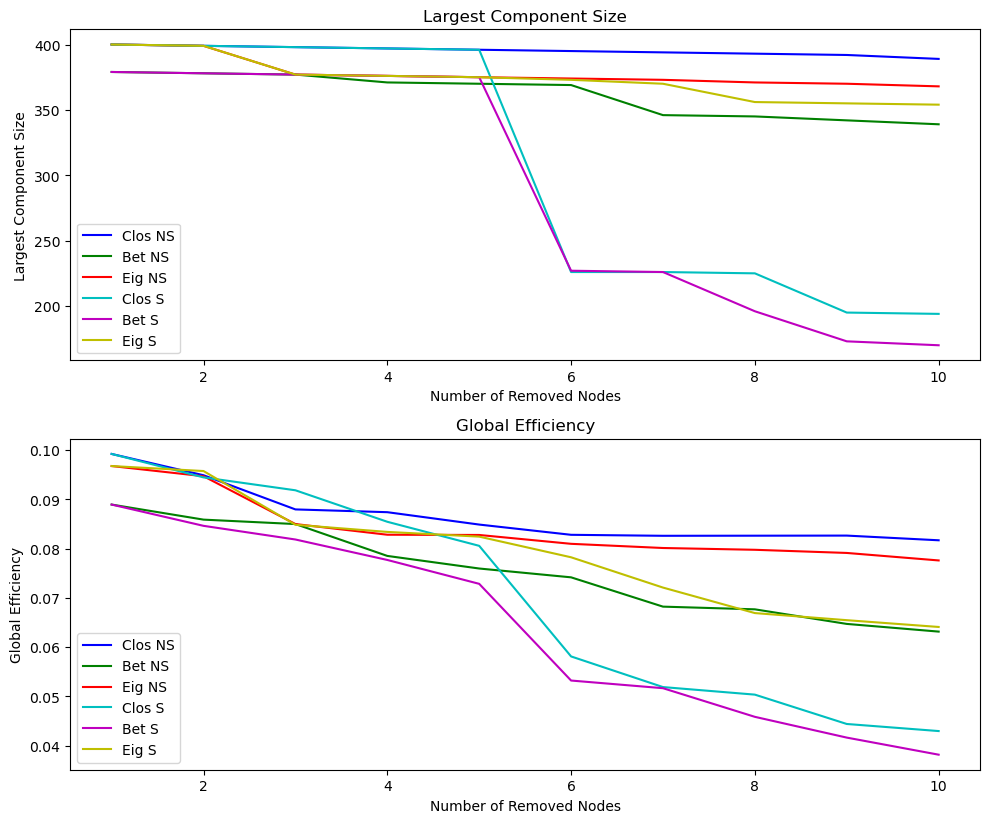

In [40]:
dataframes = {
    'Clos NS': results_clos_ns,
    'Bet NS': results_bet_ns,
    'Eig NS': results_eig_ns,
    'Clos S': results_clos_s,
    'Bet S': results_bet_s,
    'Eig S': results_eig_s
}


plt.figure(figsize=(10, 12))


metrics = ['Largest Component Size', 'Global Efficiency']
colors = ['b', 'g', 'r', 'c', 'm', 'y'] 
plot_titles = ['Largest Component Size', 'Global Efficiency']

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)  
    for j, (label, df) in enumerate(dataframes.items()):
        x = range(1, 11) 
        plt.plot(x, df[metric], label=f"{label}", color=colors[j], linestyle='-')

    plt.title(plot_titles[i])  
    plt.xlabel('Number of Removed Nodes')
    plt.ylabel(metric)
    plt.legend()


plt.tight_layout()
plt.savefig('my_plot.png')   
plt.show()

## II.Flows: Weighted Network

### Inverse weights

In [41]:
G_weighted =  G.copy() # Weighted Graph

print("Number of nodes in G_weighted after copy:", G_weighted.number_of_nodes())
print("Number of edges in G_weighted after copy:", G_weighted.number_of_edges())

Number of nodes in G_weighted after copy: 401
Number of edges in G_weighted after copy: 467


In [42]:
# Inverse weights:

# Create a list to hold the edges where flow is 0
zero_flow_edges = [(e1, e2) for e1, e2, flows in G_weighted.edges(data='flows') if flows == 0]

# Set a very small positive number for edges where flow is 0 to avoid division by zero later
for e1, e2 in zero_flow_edges:
    G_weighted[e1][e2]['flows'] = 0.00000001

# Computes inv_flows for all edges, now that there are no zero flows
inv_flows = {(e1, e2): round(1./(flows + 0.000000000001), 7)
             for e1, e2, flows in G_weighted.edges(data='flows')}

# Set the calculated inverse flows as an edge attribute
nx.set_edge_attributes(G_weighted, inv_flows, 'inv_flows')

# Print the first 10 edges with their attributes to verify the changes
print(list(G_weighted.edges(data=True))[0:10])

[('Wembley Park', 'Kingsbury', {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356, 'station_1': 'Wembley Park', 'station_2': 'Kingsbury', 'inv_flows': 8.09e-05}), ('Wembley Park', 'Neasden', {'length': 2353.1659381957816, 'line_name': 'Jubilee', 'flows': 6744, 'station_1': 'Wembley Park', 'station_2': 'Neasden', 'inv_flows': 0.0001483}), ('Wembley Park', 'Preston Road', {'length': 1419.7351657633037, 'line_name': 'Metropolitan', 'flows': 36601, 'station_1': 'Wembley Park', 'station_2': 'Preston Road', 'inv_flows': 2.73e-05}), ('Wembley Park', 'Finchley Road', {'length': 7266.37392749648, 'line_name': 'Metropolitan', 'flows': 55216, 'station_1': 'Wembley Park', 'station_2': 'Finchley Road', 'inv_flows': 1.81e-05}), ('Kingsbury', 'Queensbury', {'length': 1245.9952343630068, 'line_name': 'Jubilee', 'flows': 9419, 'station_1': 'Kingsbury', 'station_2': 'Queensbury', 'inv_flows': 0.0001062}), ('Queensbury', 'Canons Park', {'length': 1693.307343195774, 'line_name': 'Jubile

In [43]:
zero_flow_edges

[('Wandsworth Road', 'Battersea Park'),
 ('Kennington', 'Nine Elms'),
 ('Battersea Power Station', 'Nine Elms')]

In [44]:
# check edge list
df = nx.to_pandas_edgelist(G_weighted)
df.head(10)

,source,target,flows,inv_flows,station_2,length,line_name,station_1
0,Wembley Park,Kingsbury,12356.0,0.000081,Kingsbury,2916.771558,Jubilee,Wembley Park
1,Wembley Park,Neasden,6744.0,0.000148,Neasden,2353.165938,Jubilee,Wembley Park
2,Wembley Park,Preston Road,36601.0,0.000027,Preston Road,1419.735166,Metropolitan,Wembley Park
3,Wembley Park,Finchley Road,55216.0,0.000018,Finchley Road,7266.373927,Metropolitan,Wembley Park
4,Kingsbury,Queensbury,9419.0,0.000106,Queensbury,1245.995234,Jubilee,Kingsbury
5,Queensbury,Canons Park,6385.0,0.000157,Canons Park,1693.307343,Jubilee,Queensbury
6,Canons Park,Stanmore,3624.0,0.000276,Stanmore,1419.669476,Jubilee,Canons Park
7,Stratford,West Ham,91801.0,0.000011,West Ham,1673.509515,Jubilee,Stratford
8,Stratford,Mile End,12010.0,0.000083,Mile End,2805.001392,Central,Stratford
9,Stratford,Leyton,56082.0,0.000018,Leyton,2131.342926,Central,Stratford


### II.1 Weighted Betweeness Centrality 

#### Weigtht = 1/flow

In [45]:
# weighted betweenness centrality，weight is inv_flows
bet_w=nx.betweenness_centrality(G_weighted, weight='inv_flows')
# We can add these values to the nodes attributes:
nx.set_node_attributes(G_weighted,bet_w,'betweenness_w')

# To ataframe using the nodes as the index
df = pd.DataFrame(index=G_weighted.nodes())
df['station_name'] = pd.Series(nx.get_node_attributes(G_weighted, 'station_name'))
df['betweenness_w'] = pd.Series(nx.get_node_attributes(G_weighted, 'betweenness_w'))

df_bet_w = df.sort_values(["betweenness_w"], ascending=False)
df_bet_w[0:10]

,station_name,betweenness_w
Green Park,Green Park,0.572556
Bank and Monument,Bank and Monument,0.505288
Waterloo,Waterloo,0.416429
Westminster,Westminster,0.381366
Liverpool Street,Liverpool Street,0.336817
Stratford,Stratford,0.331291
Bond Street,Bond Street,0.291830
Euston,Euston,0.284236
Oxford Circus,Oxford Circus,0.270764
Warren Street,Warren Street,0.254286


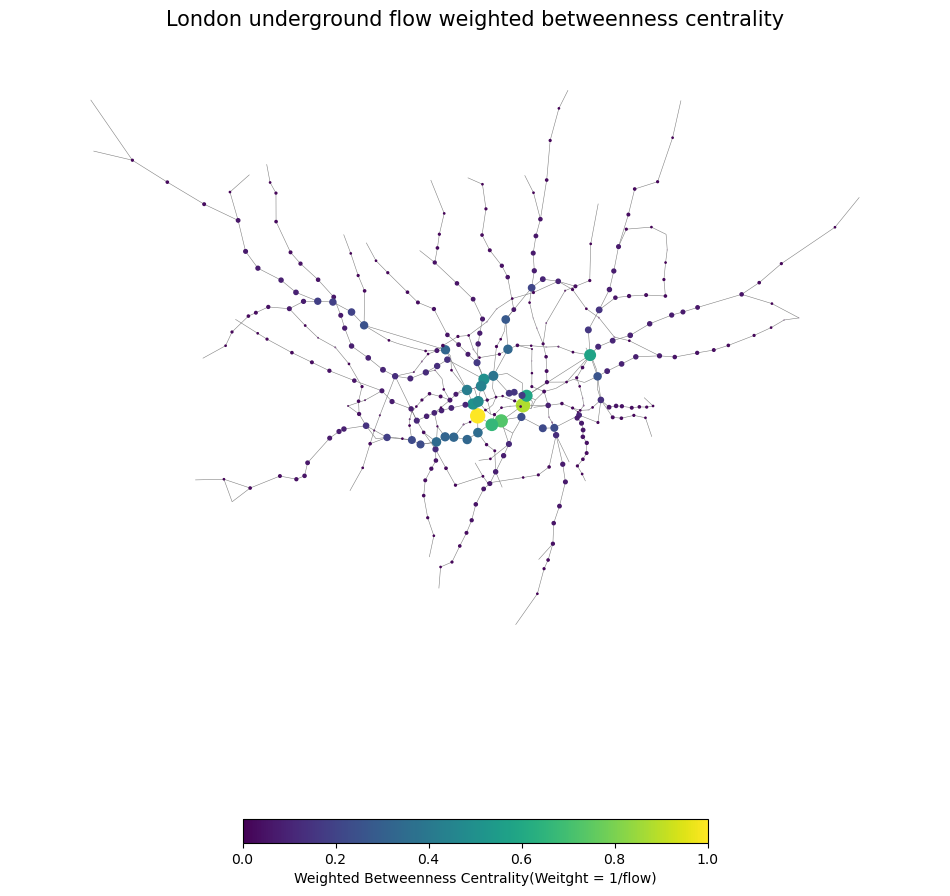

In [46]:
# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_w']) for i in G_weighted.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_w']/max(betweenness_w_values)) for i in G_weighted.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_w']/max(betweenness_w_values))*100 for i in G_weighted.nodes(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G_weighted, pos,edge_color='gray', width=0.4)

nod=nx.draw_networkx_nodes(G_weighted, pos = pos, node_color= bet_w_color, node_size= bet_w_size)

plt.colorbar(nod,label="Weighted Betweenness Centrality(Weitght = 1/flow)",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London underground flow weighted betweenness centrality",fontsize=15)
plt.savefig('bet_w.png')
plt.show()

#### Compare

In [47]:
print("Topological Betweenness Centrality:")
print(df_bet_t.head(10)) 
print("\n Flow Weighted Betweenness Centrality:")
print(df_bet_w.head(10))  

Topological Betweenness Centrality:
                                      station_name  betweenness_t
Stratford                                Stratford   23768.093434
Bank and Monument                Bank and Monument   23181.058947
Liverpool Street                  Liverpool Street   21610.387049
King's Cross St. Pancras  King's Cross St. Pancras   20373.521465
Waterloo                                  Waterloo   19464.882323
Green Park                              Green Park   17223.622114
Euston                                      Euston   16624.275469
Westminster                            Westminster   16226.155916
Baker Street                          Baker Street   15287.107612
Finchley Road                        Finchley Road   13173.758009

 Flow Weighted Betweenness Centrality:
                        station_name  betweenness_w
Green Park                Green Park       0.572556
Bank and Monument  Bank and Monument       0.505288
Waterloo                    Waterloo      

### II.2 Impact Measure for Stations Removal

#### Weighted Global Efficiency （Weight = 1/flow）

In [48]:
def flow_weighted_global_efficiency(G_weighted, weight='inv_flows'):
    """Calculate the weighted global efficiency of the graph using inverse flow as weight."""
    N = len(G_weighted)
    if N < 2: 
        return 0

    eff = 0.0
    for u in G_weighted.nodes():
        path_length = nx.single_source_dijkstra_path_length(G_weighted, u, weight=weight
        eff += sum(1.0 / d for d in path_length.values() if d > 0)


    if N * (N - 1) == 0:
        return 0

    return eff / (N * (N - 1)) 

SyntaxError: '(' was never closed (3634984177.py, line 9)

In [ ]:
#The flow weight global efficiency of the current Weitght G
print("Flow Weight Global Efficiency:", flow_weighted_global_efficiency(G_weighted))

#### Flow Weighted Global Clustering Coefficient

In [ ]:
def average_clustering_coefficient(G):
    """Calculate the unweighted average clustering coefficient of a graph."""
    avg_clustering = nx.average_clustering(G)
    return avg_clustering


In [ ]:
#The Global Clustering Coefficient of the current G_weighted
print("Global Clustering Coefficient:", average_clustering_coefficient(G_weighted))

### II.3 Stations Removal

#### Creat Copies of G_weighted

In [ ]:
Gw_1 = G_weighted.copy() #No-sequential Remove 3 highest in I.1
Gw_2= G_weighted.copy() #No-sequential Remove 3 highest in 2.1-Using Flow as Weight

Gw_3 = G_weighted.copy() #Sequential Remove 3 highest 


#### Remove 3 highest in I.1

In [ ]:
removed_nodes = []
flow_efficiencies = []
clustering_coefficients = []



for node in df_bet_t['station_name'][:3]: 
    if node in Gw_1.nodes:  
        Gw_1.remove_node(node)  
        
        
        flow_efficiency = flow_weighted_global_efficiency(Gw_1)
        clustering_coefficient = average_clustering_coefficient(Gw_1)
        
        
       
        removed_nodes.append(node)
        flow_efficiencies.append(flow_efficiency)
        clustering_coefficients.append(clustering_coefficient)


results_Gw_1 = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Flow Weighted Global Efficiency': flow_efficiencies,
    'Global Clustering Coefficient': clustering_coefficients
})

results_Gw_1

#### Remove 3 highest in II.1-Flow Weight

In [ ]:
removed_nodes = []
flow_efficiencies = []
clustering_coefficients = []



for node in df_bet_w['station_name'][:3]: 
    if node in Gw_2.nodes:  
        Gw_2.remove_node(node)  
        
       
        flow_efficiency = flow_weighted_global_efficiency(Gw_2)
        clustering_coefficient = average_clustering_coefficient(Gw_2)
        
    
        removed_nodes.append(node)
        flow_efficiencies.append(flow_efficiency)
        clustering_coefficients.append(clustering_coefficient)


results_Gw_2 = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Flow Weighted Global Efficiency': flow_efficiencies,
    'Global Clustering Coefficient': clustering_coefficients
})

results_Gw_2

#### Sequential-Remove 3 highest

In [ ]:
removed_nodes = []
flow_efficiencies = []
clustering_coefficients = []
bet_centrality = []  

for _ in range(3):
    if Gw_3.number_of_nodes() == 0:
        break  
    
    centrality = nx.betweenness_centrality(Gw_3, weight='inv_flows')
    highest_centrality_node = max(centrality, key=centrality.get)
    max_centrality_value = centrality[highest_centrality_node]  
    Gw_3.remove_node(highest_centrality_node)
    flow_efficiency = flow_weighted_global_efficiency(Gw_3)
    clustering_coefficient = average_clustering_coefficient(Gw_3)
        
        
    removed_nodes.append(highest_centrality_node)
    flow_efficiencies.append(flow_efficiency)
    clustering_coefficients.append(clustering_coefficient)
    bet_centrality.append(max_centrality_value)  
    

results_Gw_3 = pd.DataFrame({
    'Removed Node': removed_nodes,
    'Centrality': bet_centrality,
    'Flow Weighted Global Efficiency': flow_efficiencies,
    'Global Clustering Coefficient': clustering_coefficients
})
results_Gw_3

#### Plot and Analysis

In [ ]:
# 
results_Gw_1['Removal Order'] = range(1, len(results_Gw_1) + 1)
results_Gw_2['Removal Order'] = range(1, len(results_Gw_2) + 1)

# 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True)

# Flow Weighted Global Efficiency
axes[0].plot(results_Gw_1['Removal Order'], results_Gw_1['Flow Weighted Global Efficiency'], marker='o', linestyle='-', color='blue', label='Betweenness')
axes[0].plot(results_Gw_2['Removal Order'], results_Gw_2['Flow Weighted Global Efficiency'], marker='o', linestyle='-', color='red', label='Weighted Betweenness')
for i, txt in enumerate(results_Gw_1['Flow Weighted Global Efficiency']):
    axes[0].annotate(f"{txt:.2f}", (results_Gw_1['Removal Order'][i], results_Gw_1['Flow Weighted Global Efficiency'][i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(results_Gw_2['Flow Weighted Global Efficiency']):
    axes[0].annotate(f"{txt:.2f}", (results_Gw_2['Removal Order'][i], results_Gw_2['Flow Weighted Global Efficiency'][i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[0].set_title('Flow Weighted Global Efficiency')
axes[0].set_xlabel('Removal Order')
axes[0].set_ylabel('Efficiency')
axes[0].legend()
axes[0].grid(True)

# Global Clustering Coefficient
axes[1].plot(results_Gw_1['Removal Order'], results_Gw_1['Global Clustering Coefficient'], marker='o', linestyle='-', color='blue', label='Betweenness')
axes[1].plot(results_Gw_2['Removal Order'], results_Gw_2['Global Clustering Coefficient'], marker='o', linestyle='-', color='red', label='Weighted Betweenness')
for i, txt in enumerate(results_Gw_1['Global Clustering Coefficient']):
    axes[1].annotate(f"{txt:.5f}", (results_Gw_1['Removal Order'][i], results_Gw_1['Global Clustering Coefficient'][i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(results_Gw_2['Global Clustering Coefficient']):
    axes[1].annotate(f"{txt:.5f}", (results_Gw_2['Removal Order'][i], results_Gw_2['Global Clustering Coefficient'][i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[1].set_title('Global Clustering Coefficient')
axes[1].set_xlabel('Removal Order')
axes[1].set_ylabel('Coefficient')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('my_plot_2.png')  
plt.show()

In [ ]:

results_Gw_1['Removal Order'] = range(1, len(results_Gw_1) + 1)
results_Gw_2['Removal Order'] = range(1, len(results_Gw_2) + 1)
results_Gw_3['Removal Order'] = range(1, len(results_Gw_3) + 1)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True)

# Flow Weighted Global Efficiency
axes[0].plot(results_Gw_1['Removal Order'], results_Gw_1['Flow Weighted Global Efficiency'], marker='o', linestyle='-', color='blue', label='Gw_1')
axes[0].plot(results_Gw_2['Removal Order'], results_Gw_2['Flow Weighted Global Efficiency'], marker='o', linestyle='-', color='red', label='Gw_2')
axes[0].plot(results_Gw_3['Removal Order'], results_Gw_3['Flow Weighted Global Efficiency'], marker='o', linestyle='-', color='green', label='Gw_3')

# Annotate each point on the plot for Gw_1 and Gw_2 as before and add annotations for Gw_3
for i, txt in enumerate(results_Gw_3['Flow Weighted Global Efficiency']):
    axes[0].annotate(f"{txt:.2f}", (results_Gw_3['Removal Order'][i], txt), textcoords="offset points", xytext=(0,10), ha='center')

axes[0].set_title('Flow Weighted Global Efficiency')
axes[0].set_xlabel('Removal Order')
axes[0].set_ylabel('Efficiency')
axes[0].legend()
axes[0].grid(True)

# Global Clustering Coefficient
axes[1].plot(results_Gw_1['Removal Order'], results_Gw_1['Global Clustering Coefficient'], marker='o', linestyle='-', color='blue', label='Gw_1')
axes[1].plot(results_Gw_2['Removal Order'], results_Gw_2['Global Clustering Coefficient'], marker='o', linestyle='-', color='red', label='Gw_2')
axes[1].plot(results_Gw_3['Removal Order'], results_Gw_3['Global Clustering Coefficient'], marker='o', linestyle='-', color='green', label='Gw_3')

# Annotate each point on the plot for Gw_1 and Gw_2 as before and add annotations for Gw_3
for i, txt in enumerate(results_Gw_3['Global Clustering Coefficient']):
    axes[1].annotate(f"{txt:.2f}", (results_Gw_3['Removal Order'][i], txt), textcoords="offset points", xytext=(0,10), ha='center')

axes[1].set_title('Global Clustering Coefficient')
axes[1].set_xlabel('Removal Order')
axes[1].set_ylabel('Coefficient')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()